# Develop: Guidestar selection WALOP-N

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.io.votable import parse
import matplotlib.pyplot as plt
import numpy as np
import os
from pandas import DataFrame
#import seaborn as sns

from fieldgrid import FieldGridIsoLat
from utilities import cart_to_sphere, sphere_to_cart, rot_dec, rot_ra, rotate_frame

Helper functions:

In [3]:
def load_gaia(votable_files, dir_in):
    
    if isinstance(votable_files, str):
        votable_files = [votable_files]
        
    gaia_ra = []
    gaia_dec = []
    gaia_mag = []

    for i, filename in enumerate(votable_files, start=1):
        print(f'Read VOTable {i}/{len(votable_files)}..')
        votable = parse(os.path.join(dir_in, filename))
        table = votable.get_first_table()
        sel = table.array['dec'] > -1
        gaia_ra.append(table.array['ra'].data[sel])
        gaia_dec.append(table.array['dec'].data[sel])
        gaia_mag.append(table.array['phot_g_mean_mag'].data[sel])

    gaia_ra = np.concatenate(gaia_ra)
    gaia_dec = np.concatenate(gaia_dec)
    gaia_mag = np.concatenate(gaia_mag)
    
    return gaia_ra, gaia_dec, gaia_mag

In [4]:
def plot_rectangle(rectangle_center, size, **kwargs):
    """Plot a rectangle."""
    rectangle = plt.Rectangle((rectangle_center[0]-size/2, rectangle_center[1]-size/2), size, size, fill=False, **kwargs)
    plt.gca().add_artist(rectangle)

In [5]:
def plot_sciencefield(field_center, size):
    """Plot the science field."""
    plot_rectangle(field_center, size, color='0.5')
    plt.plot(field_center[0], field_center[1], color='0.5', marker='+', ms=10)

In [6]:
def plot_circle(circle_center, radius, **kwargs):
    """Plot a circle."""
    circle = plt.Circle(circle_center, radius, fill=False, **kwargs)
    plt.gca().add_artist(circle)

In [7]:
def plot_patrollingfield(radius_outer, radius_inner):
    """Plot the guider patrolling field."""
    plot_circle([0, 0], radius_inner, color='orange')
    plot_circle([0, 0], radius_outer, color='orange')
    plt.gca().set_aspect(1)
    lim = radius_outer * 1.1
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

## Read in Gaia stars

In [8]:
dir_in = 'gaia/'
votable_files = 'gaia_g_mag12_b28.vot'

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in)
gaia_coord = SkyCoord(gaia_ra, gaia_dec, unit='deg')

print('# stars:', gaia_mag.shape[0])

Read VOTable 1/1..
# stars: 373975


In [9]:
DataFrame({'mag': gaia_mag}).describe()

,mag
count,373975.000000
mean,10.776224
std,1.137597
min,1.731607
25%,10.263649
50%,11.105633
75%,11.624248
max,11.999992


## Geometry

![Test](info/Guider_N_region.png)

**Notes:**
- The big square shows the science field.
- The small squares indicate different positions of the guide field along circular path around the science field.
- Different from the sketch, guide field positions are allowed 360 degrees around the science field, not just on the 90 degrees bow that is shown.
- The guide camera FoV is 72'' by 36''. According to John, the long side is along the radial axis.
- The separation between the science field center and the guide camera center is 22.5 arcmin, according to John, Sid's confirmation pending.

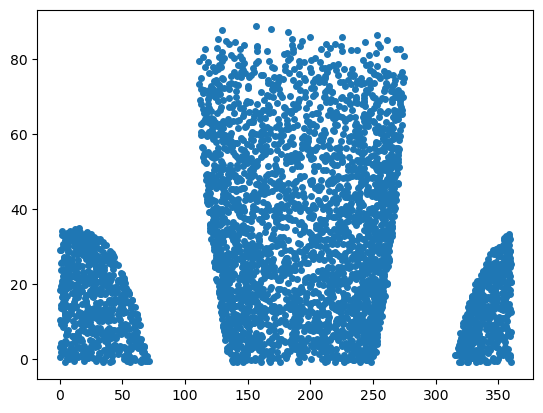

In [10]:
plt.plot(gaia_ra[::100], gaia_dec[::100], linestyle='None', marker='o', ms=4);

## Demonstration

In [11]:
field_size = 30 * 60 # arcsec
guide_radius = 22.5 * 60 # arcsec
cam_size = [72, 36] # arcsec
limit = 0 # arcsec
scale = np.radians(1 / 3600) # rad / arcsec

field_size = Angle(field_size * scale, unit='rad')

### Candidates in the full guider region

In [12]:
field_center = SkyCoord(150, 80, unit='deg')
guide_radius_inner = Angle((guide_radius - cam_size[0] / 2. + limit) * scale, unit='rad')
guide_radius_outer = Angle((guide_radius + cam_size[0] / 2. - limit) * scale, unit='rad')

In [13]:
sel_outer = gaia_coord.separation(field_center) < guide_radius_outer
sel_inner = gaia_coord[sel_outer].separation(field_center) < guide_radius_inner
i_cand = np.nonzero(sel_outer)[0][~sel_inner]
gaia_coord_circle = gaia_coord[sel_outer]
gaia_coord_cand = gaia_coord[i_cand]

In [14]:
gaia_coord_cand

<SkyCoord (ICRS): (ra, dec) in deg
    [(152.15020053, 79.92331843), (152.15757366, 80.07638237),
     (149.77188648, 80.3803066 ), (149.77075147, 80.37989785)]>

In [15]:
gaia_mag[i_cand]

array([11.826118, 10.538339, 10.146392,  7.825651], dtype=float32)

In [16]:
gaia_circle_rot_ra, gaia_circle_rot_dec = rotate_frame(gaia_coord_circle.ra.rad, gaia_coord_circle.dec.rad, field_center)
gaia_cand_rot_ra, gaia_cand_rot_dec = rotate_frame(gaia_coord_cand.ra.rad, gaia_coord_cand.dec.rad, field_center)

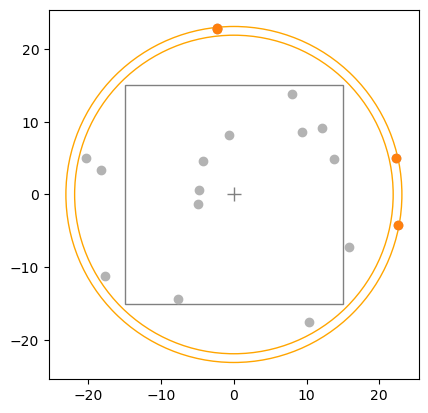

In [17]:
plot_sciencefield([0, 0], field_size.arcmin)
plot_patrollingfield(guide_radius_outer.arcmin, guide_radius_inner.arcmin)
plt.plot(np.degrees(gaia_circle_rot_ra)*60, np.degrees(gaia_circle_rot_dec)*60, linestyle='None', marker='o', color='0.7')
plt.plot(np.degrees(gaia_cand_rot_ra)*60, np.degrees(gaia_cand_rot_dec)*60, linestyle='None', marker='o', color='tab:orange');

### Orientation of the guide camera

We use simple cartesian geometry in the rotated coordinate system:

In [18]:
alpha = np.mod(np.arctan2(gaia_cand_rot_dec, gaia_cand_rot_ra), 2 * np.pi) - np.pi / 2
np.degrees(alpha)

array([259.497144  , -77.37326595,   5.72283999,   5.75749862])

## Class implementation

Create guide star selection class:

In [8]:
from guidestars import GuideStarWalopN, load_gaia

In [9]:
selector = GuideStarWalopN()

### Set, save, load parameters

Define parameters:

In [10]:
guide_radius = 22.5 * 60 # arcsec
field_size = 30 * 60 # arcsec
cam_size = [72, 36] # arcsec
home_pos = np.radians(0) # radians
limit = 0 # arcsec
scale = np.radians(1 / 3600) # rad / arcsec
scale_rot = 180 / np.pi # degrees / radian
n_min = 2
n_max = 3

In [11]:
selector.set_params(
            guide_radius, field_size, cam_size, home_pos, limit=0,
            scale=scale, scale_rot=scale_rot, n_min=n_min, n_max=n_max)

Save/load parameters to/from JSON file:

In [12]:
selector.save_params('guide_walop_n.json')

Guide parameters saved in: guide_walop_n.json


In [13]:
selector.load_params('guide_walop_n.json')

Parameters loaded from guide_walop_n.json.


### Add stars and stars to avoid

Load Gaia stars:

In [14]:
dir_in = 'gaia/'
votable_files = 'gaia_g_mag12_b28.vot'

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in, dec_lolim=-1)
gaia_coord = SkyCoord(gaia_ra, gaia_dec, unit='deg')

print('# stars:', gaia_mag.shape[0])

Read VOTable 1/1..
# stars: 373975


Separate bright stars:

In [15]:
gaia_mag_limit = 7
sel = gaia_mag < gaia_mag_limit
gaia_bright_ra = gaia_ra[sel]
gaia_bright_dec = gaia_dec[sel]
gaia_ra = gaia_ra[~sel]
gaia_dec = gaia_dec[~sel]
gaia_coord = gaia_coord[~sel]
gaia_mag = gaia_mag[~sel]
print(f'{np.sum(sel)} bright stars separated.')

4147 bright stars separated.


Add bright stars that should be avoided:

In [16]:
selector.set_stars_to_avoid(np.radians(gaia_bright_ra), np.radians(gaia_bright_dec))

4147 coordinates of bright stars set that will be avoided in the guide camera.


Add stars:

In [17]:
selector.set_stars(np.radians(gaia_ra), np.radians(gaia_dec), gaia_mag)

369828 candidate stars added.
Magnitude range: 7.0 - 12.0


### Select guide stars for specific sky location

In [29]:
field_center = SkyCoord(150, 80, unit='deg')
guidestars, coord_rot_guidestars, coord_rot_cand, coord_rot_avoid = selector.select(
    field_ra=field_center.ra.rad, field_dec=field_center.dec.rad, return_coord=True)
guidestars

[{'guidestar_ra': 2.6139927362803164,
  'guidestar_dec': 1.4028938698788573,
  'guidestar_mag': 7.825651,
  'cam_rot': 5.7574986228706715},
 {'guidestar_ra': 2.614012546018729,
  'guidestar_dec': 1.4029010038998369,
  'guidestar_mag': 10.146392,
  'cam_rot': 5.72283999470609},
 {'guidestar_ra': 2.655650642206711,
  'guidestar_dec': 1.397596525398743,
  'guidestar_mag': 10.538339,
  'cam_rot': 282.6267340457015}]

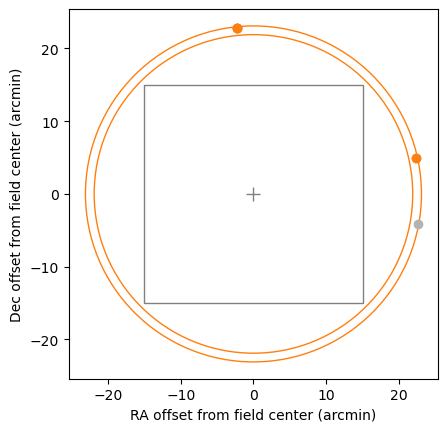

In [30]:
selector.visualize_selection(coord_rot_guidestars, coord_rot_cand, coord_rot_avoid);

### Calculate exposure times 

We implement the magnitude-to-exposure time function in a lambda function and hand it to the `select()` method. Then it will be automatically applied to each guidestar:

In [31]:
mag_ref = 16
exp_ref = 5 # sec
exp_min = 1 # sec
mag_to_exp = lambda mag: np.maximum(exp_ref * 10**((mag - mag_ref) / 2.5), exp_min)

In [32]:
guidestars = selector.select(field_ra=field_center.ra.rad, field_dec=field_center.dec.rad, mag_to_exp=mag_to_exp)
guidestars

[{'guidestar_ra': 2.6139927362803164,
  'guidestar_dec': 1.4028938698788573,
  'guidestar_mag': 7.825651,
  'cam_rot': 5.7574986228706715,
  'exp': 1.0},
 {'guidestar_ra': 2.614012546018729,
  'guidestar_dec': 1.4029010038998369,
  'guidestar_mag': 10.146392,
  'cam_rot': 5.72283999470609,
  'exp': 1.0},
 {'guidestar_ra': 2.655650642206711,
  'guidestar_dec': 1.397596525398743,
  'guidestar_mag': 10.538339,
  'cam_rot': 282.6267340457015,
  'exp': 1.0}]

### Select guide stars for field grid

Create Northern field grid:

In [18]:
grid = FieldGridIsoLat(verbose=1)
grid.load_params('grid_test_n.json')

Create fields..
    Done                                                    
Final number of fields: 1097
Grid parameters loaded from grid_test_n.json.


In [22]:
guidestars = selector.select(fieldgrid=grid)

Iterate through field grid..
  done.                             


Results:
--------------------------------------------
Guide stars selected:           1477
Fields without guide stars:      288 (26.3%)
--------------------------------------------
Median number of field stars:      1
Mean number of field stars:        1
Max number of field stars:         3


In [35]:
selector.check_results(verbose=2)

Results:
--------------------------------------------
Guide stars selected:           1477
Fields without guide stars:      288 (26.3%)
--------------------------------------------
Median number of field stars:      1
Mean number of field stars:        1
Max number of field stars:         3
--------------------------------------------
No. of guide stars: No. of fields
 0: 288
 1: 353
 2: 244
 3: 212
--------------------------------------------


### Add higher magnitude stars

Add stars with higher magnitudes and automatically update guide collections for fields, where not enough are available yet:

In [36]:
dir_in = 'gaia/'
votable_files = 'gaia_g_mag12-13_b28.vot'

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in, dec_lolim=-1)

print('# stars:', gaia_mag.shape[0])

Read VOTable 1/1..
# stars: 412800


Add stars:

In [37]:
selector.set_stars(np.radians(gaia_ra), np.radians(gaia_dec), gaia_mag)

Overwriting previous stars..
412800 candidate stars added.
Magnitude range: 12.0 - 13.0

641 field do not have enough guide stars. Search for more..
  done.                             


Results:
--------------------------------------------
Guide stars selected:           2048
Fields without guide stars:       83 (7.6%)
--------------------------------------------
Median number of field stars:      2
Mean number of field stars:        2
Max number of field stars:         3


In [38]:
selector.check_results(verbose=2)

Results:
--------------------------------------------
Guide stars selected:           2048
Fields without guide stars:       83 (7.6%)
--------------------------------------------
Median number of field stars:      2
Mean number of field stars:        2
Max number of field stars:         3
--------------------------------------------
No. of guide stars: No. of fields
 0:  83
 1: 192
 2: 610
 3: 212
--------------------------------------------


## Trials with spherical coordinates

<div class="alert alert-block alert-warning">
I tested the following approach first, but decided not to use it. Instead I am using the cartesian coordinate simplification above.
</div>

In [39]:
field_center = SkyCoord(0, 0, unit='deg')
n = 8
a = 10 # deg
a = np.radians(a)
ra = -a * np.sin(np.linspace(0, 2*np.pi, n+1))
dec = a * np.cos(np.linspace(0, 2*np.pi, n+1))
x, y, z = sphere_to_cart(ra, dec)
x, y, z = rot_dec(x, y, z, field_center.dec.rad)
x, y, z = rot_ra(x, y, z, field_center.ra.rad)
ra_rot, dec_rot = cart_to_sphere(x, y, z)
ra_rot = np.where(ra_rot > np.pi, ra_rot-2*np.pi, ra_rot)
stars = SkyCoord(ra_rot, dec_rot, unit='rad')

In [40]:
a = np.pi / 2. - stars.dec.rad
b = np.pi / 2. - field_center.dec.rad
#gamma = np.absolute(stars.ra.rad - field_center.ra.rad)
gamma = stars.ra.rad - field_center.ra.rad

In [41]:
cos_c = np.cos(a) * np.cos(b) + np.sin(a) * np.sin(b) * np.cos(gamma)
c = np.arccos(cos_c)
sin_alpha = np.sin(a) / np.sin(c) * np.sin(gamma)
sin_alpha = np.round(sin_alpha, 8)
#sin_alpha = np.where(sin_alpha > 1, 1, sin_alpha) # fix rounding errors
#sin_alpha = np.where(sin_alpha < -1, -1, sin_alpha) # fix rounding errors
alpha = np.arcsin(sin_alpha)

DataFrame({'a': a, 'b': b, 'gamma': gamma, 'cos(c)': cos_c, 'c': c, 'sin(alpha)': sin_alpha, 'alpha': np.degrees(alpha)})

,a,b,gamma,cos(c),c,sin(alpha),alpha
0,1.396263,1.570796,0.000000e+00,0.984808,0.174533,0.000000,0.00000
1,1.447383,1.570796,6.159772e+00,0.984846,0.174311,-0.704402,-44.78128
2,1.570796,1.570796,6.108652e+00,0.984808,0.174533,-1.000000,-90.00000
3,1.694210,1.570796,6.159772e+00,0.984846,0.174311,-0.704402,-44.78128
4,1.745329,1.570796,0.000000e+00,0.984808,0.174533,0.000000,0.00000
5,1.694210,1.570796,1.234134e-01,0.984846,0.174311,0.704402,44.78128
6,1.570796,1.570796,1.745329e-01,0.984808,0.174533,1.000000,90.00000
7,1.447383,1.570796,1.234134e-01,0.984846,0.174311,0.704402,44.78128
8,1.396263,1.570796,4.274824e-17,0.984808,0.174533,0.000000,0.00000


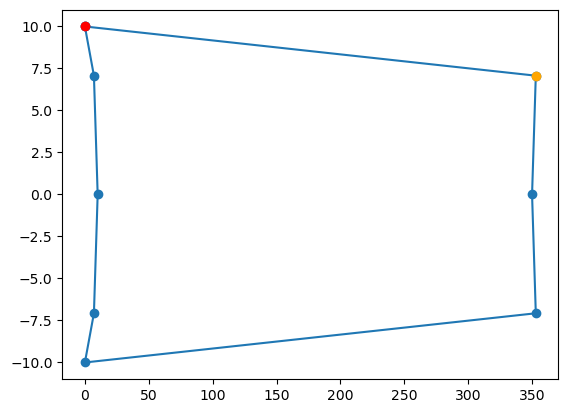

In [42]:
plt.plot(stars.ra.deg, stars.dec.deg, marker='o')
plt.plot(stars.ra.deg[0], stars.dec.deg[0], marker='o', color='r')
plt.plot(stars.ra.deg[1], stars.dec.deg[1], marker='o', color='orange')
#plt.gca().set_aspect(1);

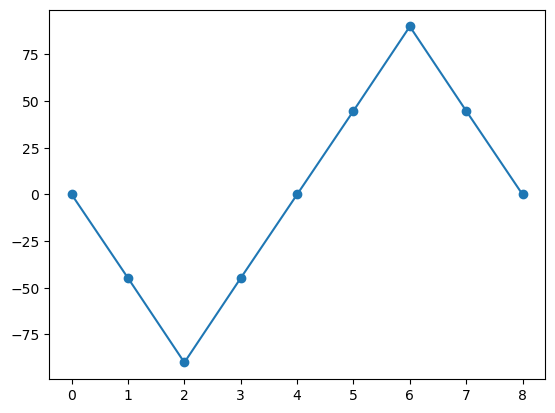

In [43]:
plt.plot(np.degrees(alpha), marker='o');

In [44]:
stars_ra_rot, stars_dec_rot = rotate_frame(stars.ra.rad, stars.dec.rad, field_center)

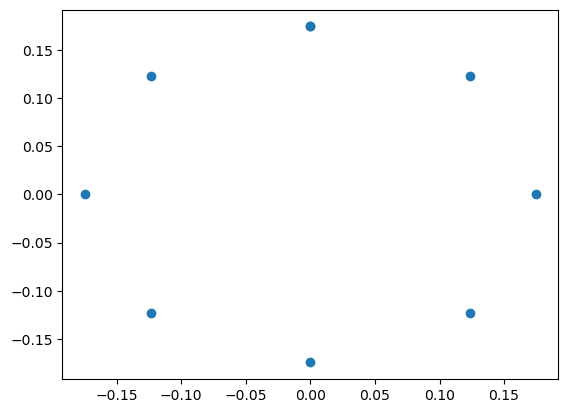

In [45]:
plt.plot(stars_ra_rot, stars_dec_rot, 'o')

In [46]:
sel_ra_pos = stars_ra_rot >= 0
sel_dec_pos = stars_dec_rot >= 0
sel = np.logical_and(~sel_ra_pos, ~sel_dec_pos)
alpha[sel] = np.pi - alpha[sel]
sel = np.logical_and(sel_ra_pos, ~sel_dec_pos)
alpha[sel] = np.pi + alpha[sel]
sel = np.logical_and(sel_ra_pos, sel_dec_pos)
alpha[sel] = 2 * np.pi - alpha[sel]
alpha = np.mod(alpha, 2*np.pi)

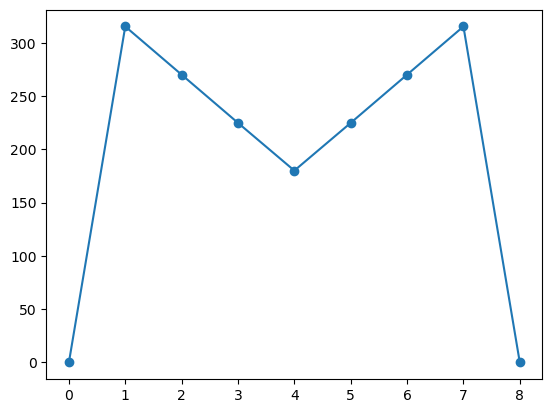

In [47]:
plt.plot(np.degrees(alpha), marker='o');

**Notes:**
- We do not get the quadrants right.
- We cannot fix this with the quantities we calculate above.
- We can only fix this, when we know if the stars are at RA / dec higher or lower than the field center. However, this will break around RA=0 and close to the poles. 
- We need to rotate the frame to field center = (0, 0). Then correct the quadrants.